**LANDSCAPE STRUCTURE COMPUTATION**

This notebook is divided into three major areas:

1. _Determination of Class-level Metrics which will help understand the characteristics of each class within the landscape;_
2. _Moving Window Assessment follows, to establish the most appropriate (or stable) window size that will be used to perform the landscape-level assessment of the entire country, and_
3. _Computation of landscape-level metrics and mapping them, for enhanced visual assessment._

**Install and Import Necessary Libraries**

In [1]:
#!pip install numpy geopandas pylandstats pandas matplotlib rasterio shapely

import numpy as np
import geopandas as gpd
import pylandstats as pls
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio
from rasterio.enums import Resampling
from rasterio.features import shapes
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.transform import from_origin
from shapely.geometry import box, shape
import os

Module c:\Users\EnechePSU\.conda\envs\gee\envs\geemap-env\lib\site-packages\pylandstats\landscape.py has not been compiled for Transonic-Numba


**Load the Landscape Character Data (Raster)**

In [2]:
# Load the GeoJSON file into a GeoDataFrame
geojson_file = 'all_output/complete_landscape_ch_polygons_colors.geojson'
gdf = gpd.read_file(geojson_file)

# Ensure the GeoDataFrame is in the correct CRS (Coordinate Reference System)
gdf = gdf.to_crs(epsg=3857)

# Define the raster parameters
raster_width = 1000
raster_height = 1000
raster_transform = rasterio.transform.from_bounds(*gdf.total_bounds, raster_width, raster_height)
raster_shape = (raster_height, raster_width)

# Rasterize the GeoDataFrame
raster = rasterio.features.rasterize(
    ((geom, value) for geom, value in zip(gdf.geometry, gdf['raster_val'])),
    out_shape=raster_shape,
    transform=raster_transform,
    fill=0,
    dtype='int32'
)

# Save the raster to a temporary file
original_raster = 'all_output/complete_landscape_ch_raster.tif'
with rasterio.open(original_raster, 'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=raster_transform
) as dst:
    dst.write(raster, 1)
    
# Further, ensure or replace nodata
landscape_raster = 'all_output/complete_landscape_ch_raster_nodata.tif'

# Open the raster file
with rasterio.open(original_raster) as src:
    # Read the raster data
    data = src.read(1)
    
    # Check if NoData is set, and if not, set a default value
    if src.nodata is None:
        nodata_value = 0 
    else:
        nodata_value = src.nodata
    
    # Set all 0 values to NoData
    data[data == 0] = nodata_value

    # Update metadata to reflect NoData
    meta = src.meta.copy()
    meta.update(nodata=nodata_value)

    # Write out the modified raster
    with rasterio.open(landscape_raster, 'w', **meta) as dst:
        dst.write(data, 1)
        
print("Metadata of the output raster:")
for key, value in meta.items():
    print(f"{key}: {value}")

Metadata of the output raster:
driver: GTiff
dtype: int32
nodata: 0
width: 1000
height: 1000
count: 1
crs: EPSG:3857
transform: | 1335.00, 0.00, 298500.00|
| 0.00,-1084.00, 1561500.00|
| 0.00, 0.00, 1.00|


**1. Compute Class-Level Landscape Metrics**

- Percentage of Landscape (PLAND): Represents the proportion of the landscape occupied by each class. Higher values indicate greater dominance.
- Patch Density (PD): Number of patches per unit area. Higher values indicate more fragmented landscapes. Maximum PD is attained when every cell is a separate patch.
- Largest Patch Index (LPI): The percentage of total landscape area comprised by the largest patch. Higher values indicate dominance by a single patch.
- Total Edge (TE): The total length of all edge segments involving the class. Higher values indicate more edge habitats.
- Edge Density (ED): Total edge length per unit area. Higher values indicate greater landscape complexity. ED equals 0 when the entire landscape and its border consist of the corresponding patch class.
- Landscape Shape Index (LSI): This is a measure of class aggregation. LSI equals 1 when the entire landscape consists of a single patch of the corresponding class, and increases without limit as the patches of such class become more disaggregated.

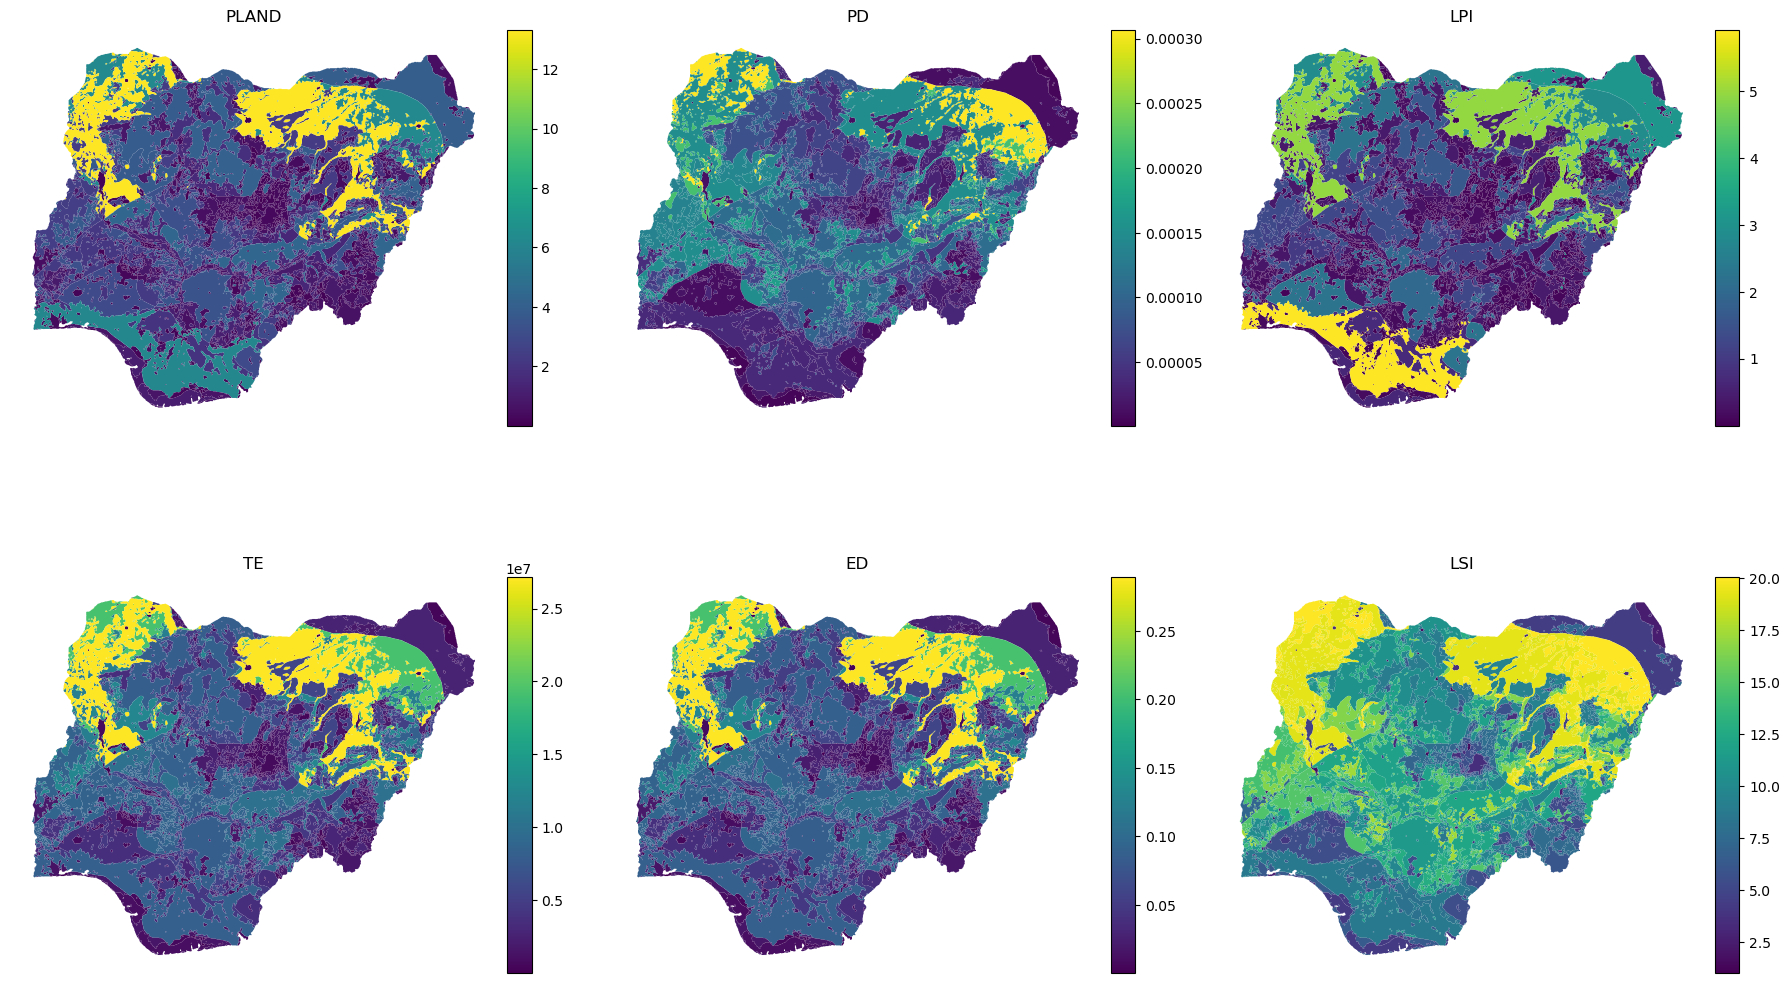

      raster_val    area_sqkm  Elevation  Climate  Landcover  Geology  \
4591       16095  6029.676359          1        1         95        4   
4592       16010    74.129496          1        1         10        4   

      Cluster25 land_code25    Elevation_Class Climate_Class  ...  \
4591         16      C1G4E1  Very Low (0-100m)           Wet  ...   
4592         16      C1G4E1  Very Low (0-100m)           Wet  ...   

                                            description color_auto    color  \
4591  A predominantly mangroves type of land cover w...    #167b4f  #00DD7D   
4592  A predominantly tree cover type of land cover ...    #337f33  #8A9A5B   

                                               geometry  \
4591  POLYGON ((616500.230 535500.230, 616500.000 53...   
4592  POLYGON ((666500.230 482500.230, 666500.000 48...   

      proportion_of_landscape  patch_density largest_patch_index total_edge  \
4591                 0.989461       0.000005            0.639615  1070533.0  

In [3]:
# Initialize the Landscape object
landscape = pls.Landscape(
    landscape=landscape_raster,
    res=(raster_transform.a, abs(raster_transform.e)),  # Ensure pixel size is positive
    transform=raster_transform,
    nodata=0  # assuming 0 is the nodata value
)

# Compute class-level metrics
class_metrics_df = landscape.compute_class_metrics_df(
    metrics=['proportion_of_landscape', 'patch_density', 'largest_patch_index', 'total_edge', 'edge_density', 'landscape_shape_index']
)

# Convert the class metrics to a DataFrame
class_metrics_df = pd.DataFrame(class_metrics_df, index=landscape.classes)

# Save class-level metrics to a CSV file
class_metrics_df.to_csv('all_output/class_level_metrics.csv', index=True)

# Merge class-level metrics with the original GeoDataFrame
gdf = gdf.merge(class_metrics_df, left_on='raster_val', right_index=True, how='left')

# Save the GeoDataFrame with the computed metrics to .geojson and .csv file formats
gdf.to_file('all_output/landscape_ch_polygons_with_class_metrics.geojson', driver='GeoJSON')
gdf.drop(columns='geometry').to_csv('all_output/landscape_ch_polygons_with_class_metrics.csv', index=False)

# Plot each class-level metric spatially
metrics = ['proportion_of_landscape', 'patch_density', 'largest_patch_index', 'total_edge', 'edge_density', 'landscape_shape_index']
metric_titles = {
    'proportion_of_landscape': 'PLAND',
    'patch_density': 'PD',
    'largest_patch_index': 'LPI',
    'total_edge': 'TE',
    'edge_density': 'ED',
    'landscape_shape_index': 'LSI',
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    gdf.plot(column=metric, ax=ax, legend=True, cax=cax, cmap='viridis')
    ax.set_title(metric_titles[metric])
    ax.set_axis_off()

plt.tight_layout()
plt.savefig('all_output/class_level_metrics_spatial_plot.png')
plt.savefig('all_output/class_level_metrics_spatial_plot.svg')
plt.show()
print(gdf.tail(2))

**2. Computation of Landscape-Level Metrics**

First, we ascertain the most stable moving window size (8 - 24km) for our landscape-level metrics computation. Secondly, we generate the grids and thirdly, we implement them in computing our chosen metrics.


_**2.1 Assessment of (Stable) Moving Window Size**_


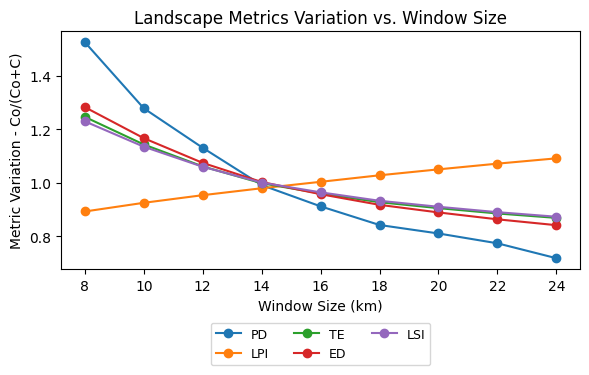

Landscape Metrics Variation by Window Size:
   patch_density  largest_patch_index  total_edge  edge_density  \
0       1.525820             0.893205    1.246614      1.283055   
1       1.278825             0.925643    1.143581      1.167182   
2       1.131166             0.954143    1.061579      1.074776   
3       0.991912             0.980049    0.998841      1.003445   
4       0.912428             1.004080    0.960691      0.957796   
5       0.842728             1.028464    0.927821      0.918079   
6       0.811051             1.050640    0.905719      0.889664   
7       0.774335             1.071961    0.885799      0.863936   
8       0.718658             1.091814    0.869354      0.842046   

   landscape_shape_index  window_size  
0               1.230095            8  
1               1.135331           10  
2               1.060348           12  
3               1.001196           14  
4               0.964771           16  
5               0.933192           18  
6    

In [4]:
# Function to filter out small patches
def filter_small_patches(gdf, min_patch_size):
    return gdf[gdf.geometry.area > min_patch_size]

# Function to compute landscape metrics for different window sizes
def compute_landscape_metrics_for_window_sizes(gdf, window_sizes, metrics, raster_transform, raster_shape, raster_file):
    results = {metric: [] for metric in metrics}
    results['window_size'] = []

    for window_size in window_sizes:
        # Create a moving window
        gdf_moving_window = gdf.copy()
        gdf_moving_window['geometry'] = gdf_moving_window.geometry.buffer(window_size * 1000)

        # Filter out small patches
        gdf_filtered = filter_small_patches(gdf_moving_window, min_patch_size=1000)  # Example threshold, adjust as needed

        # Rasterize the GeoDataFrame
        raster = rasterio.features.rasterize(
            ((geom, value) for geom, value in zip(gdf_filtered.geometry, gdf_filtered['raster_val'])),
            out_shape=raster_shape,
            transform=raster_transform,
            fill=0,
            dtype='int32'
        )

        # Save the raster to the temporary file
        with rasterio.open(
            landscape_raster, 'w',
            driver='GTiff',
            height=raster.shape[0],
            width=raster.shape[1],
            count=1,
            dtype=raster.dtype,
            crs=gdf_filtered.crs,
            transform=raster_transform
        ) as dst:
            dst.write(raster, 1)

        # Initialize the Landscape object
        landscape = pls.Landscape(
            landscape=landscape_raster,
            res=(raster_transform.a, abs(raster_transform.e)),  # Ensure pixel size is positive
            transform=raster_transform,
            nodata=0  # assuming 0 is the nodata value
        )

        # Compute metrics for the landscape
        for metric_name in metrics:
            metric_func = getattr(landscape, metric_name)
            metric_value = metric_func()
            # Handle NaN or infinite values by setting them to zero
            if isinstance(metric_value, np.ndarray):
                metric_value = np.nan_to_num(metric_value, nan=0.0, posinf=0.0, neginf=0.0)
            results[metric_name].append(metric_value)

        results['window_size'].append(window_size)

    return pd.DataFrame(results)

# Define the moving window sizes (in km)
window_sizes = [8, 10, 12, 14, 16, 18, 20, 22, 24]

# Define the landscape metrics to compute
landscape_metrics = [
    'patch_density', 
    'largest_patch_index', 
    'total_edge', 
    'edge_density', 
    'landscape_shape_index'
]

# Abbreviations for the metrics
metric_abbreviations = {
    'patch_density': 'PD',
    'largest_patch_index': 'LPI',
    'total_edge': 'TE',
    'edge_density': 'ED',
    'landscape_shape_index': 'LSI'
}

# Compute landscape metrics for different window sizes
landscape_metrics_df = compute_landscape_metrics_for_window_sizes(
    gdf, window_sizes, landscape_metrics, raster_transform, raster_shape, landscape_raster
)

# Calculate the variation (coefficient of variation) for the metrics
variation_df = landscape_metrics_df.copy()
for metric in landscape_metrics:
    variation_df[metric] = variation_df[metric] / (variation_df[metric].mean() + 1e-6)  # Avoid division by zero

# Save the results to a CSV file
variation_df.to_csv('all_output/landscape_metrics_variation_by_window_size.csv', index=False)

# Plot the landscape metrics variation for different window sizes
plt.figure(figsize=(6, 4))
for metric in landscape_metrics:
    plt.plot(variation_df['window_size'], variation_df[metric], marker='o', label=metric_abbreviations[metric])
plt.xlabel('Window Size (km)')
plt.ylabel('Metric Variation - Co/(Co+C)')
plt.title('Landscape Metrics Variation vs. Window Size')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=9)  # Move legend to bottom
plt.tight_layout()
plt.savefig('all_output/landscape_metrics_variation_by_window_size_plot.png')
plt.show()

# Display landscape metrics variation
print("Landscape Metrics Variation by Window Size:")
print(variation_df)

_**2.2 Grid Generation (14km)**_

This is based on the Window Size (14km) detected above or can be modified, if otherwsise. Grids are also clipped to exact boundary of the study area (i.e. landscape character raster file).

In [5]:
# Input raster file
input_raster = 'all_output/complete_landscape_ch_raster.tif'
output_raster = 'all_output/complete_landscape_ch_raster_nodata.tif'

# Open the raster file
with rasterio.open(input_raster) as src:
    # Read the raster data
    data = src.read(1)
    
    # Check if NoData is set, and if not, set a default value
    if src.nodata is None:
        nodata_value = 0 
    else:
        nodata_value = src.nodata
    
    # Set all 0 values to NoData
    data[data == 0] = nodata_value

    # Update metadata to reflect NoData
    meta = src.meta.copy()
    meta.update(nodata=nodata_value)

    # Write out the modified raster
    with rasterio.open(output_raster, 'w', **meta) as dst:
        dst.write(data, 1)
        
print("Metadata of the output raster:")
for key, value in meta.items():
    print(f"{key}: {value}")

Metadata of the output raster:
driver: GTiff
dtype: int32
nodata: 0
width: 1000
height: 1000
count: 1
crs: EPSG:3857
transform: | 1335.00, 0.00, 298500.00|
| 0.00,-1084.00, 1561500.00|
| 0.00, 0.00, 1.00|


In [6]:
# Path to the raster file
landscape_raster = 'all_output/complete_landscape_ch_raster_nodata.tif'

# Open the raster file
with rasterio.open(landscape_raster) as src:
    # Get raster properties
    transform = src.transform
    cell_size_x, cell_size_y = transform[0], transform[4]  # Get cell size in x and y directions
    
    # Extract the exact boundary (footprint) of the raster (non-nodata areas)
    mask = src.dataset_mask()
    shapes_generator = shapes(mask, transform=transform)
    
    # Create a GeoSeries of the raster footprint
    footprint_shapes = [shape(geom) for geom, value in shapes_generator if value != 0]
    raster_footprint = gpd.GeoSeries(footprint_shapes, crs=src.crs).unary_union  # Combine all shapes into a single geometry

# Define grid size in meters
grid_size_m = 14000  # 14km grid size

# Get the bounds of the raster footprint
minx, miny, maxx, maxy = raster_footprint.bounds

# Create grid cells
grid_cells = []
id_counter = 1

for i in range(int((maxy - miny) / grid_size_m) + 1):  # Adjusted to cover the full extent
    for j in range(int((maxx - minx) / grid_size_m) + 1):  # Adjusted to cover the full extent
        # Calculate coordinates of the grid cell
        cell_minx = minx + j * grid_size_m
        cell_miny = miny + i * grid_size_m
        cell_maxx = cell_minx + grid_size_m
        cell_maxy = cell_miny + grid_size_m
        
        # Create a box polygon for the grid cell
        cell_bounds = box(cell_minx, cell_miny, cell_maxx, cell_maxy)
        
        # Clip the grid cell to the raster footprint
        clipped_cell = cell_bounds.intersection(raster_footprint)
        
        # Add the clipped cell to the list only if it has a non-zero area
        if not clipped_cell.is_empty:
            grid_cells.append({'id': id_counter, 'geometry': clipped_cell})
            id_counter += 1

# Create a GeoDataFrame from the grid cells with the same CRS as the raster
grid_gdf = gpd.GeoDataFrame(grid_cells, crs=src.crs)

grid_gdf['id'] = grid_gdf['id'].astype(int) #to integers

# Save the trimmed grid
output_path = 'all_output/clipped_and_trimmed_empty_14km_grid.geojson'
grid_gdf.to_file(output_path, driver='GeoJSON')

print('Clipped and trimmed grid file created')
print(grid_gdf.tail(2))


Clipped and trimmed grid file created
        id                                           geometry
5001  5002  POLYGON ((620500.000 1555500.000, 606500.000 1...
5002  5003  POLYGON ((620500.000 1555500.000, 620500.000 1...


_**2.3 Perform Zonal Analysis**_


In [7]:
za = pls.ZonalAnalysis( # Refer to pylandstats...
    landscape=landscape_raster,
    masks=grid_gdf,  # Pass the GeoDataFrame with the zone polygons
    masks_index_col='id',  # Specify the column with the zone IDs
    # Specify the neighborhood rule to determine patch adjacencies.
    # Input: '8' (queen's case/Moore neighborhood) or '4' (rook's case/Von Neumann neighborhood).
    neighborhood_rule=8 
)

_**2.4 Perform Landscape-Level Metrics Computation**_

In [ ]:
# Define the metrics to compute
metrics = [
    'patch_density', 
    'largest_patch_index', 
    'total_edge', 
    'edge_density', 
    'landscape_shape_index'
]

# Compute the metrics for each zone
zonal_metrics_df = za.compute_landscape_metrics_df(metrics=metrics)

# Export the results to a CSV file
output_csv_path = 'all_output/zonal_landscape_metrics_14km_grid_main.csv'
output_geojson_path = 'all_output/zonal_landscape_metrics_14km_grid_main.geojson'

zonal_metrics_df.to_csv(output_csv_path, index=True)

# Merge the metrics DataFrame with the GeoDataFrame
zonal_metrics_merged_gdf = grid_gdf.merge(zonal_metrics_df, left_on='id', right_index=True, how='left')

# Save the merged GeoDataFrame
zonal_metrics_merged_gdf.to_file(output_geojson_path, driver='GeoJSON')

print(f"Zonal landscape metrics saved to {output_csv_path}")

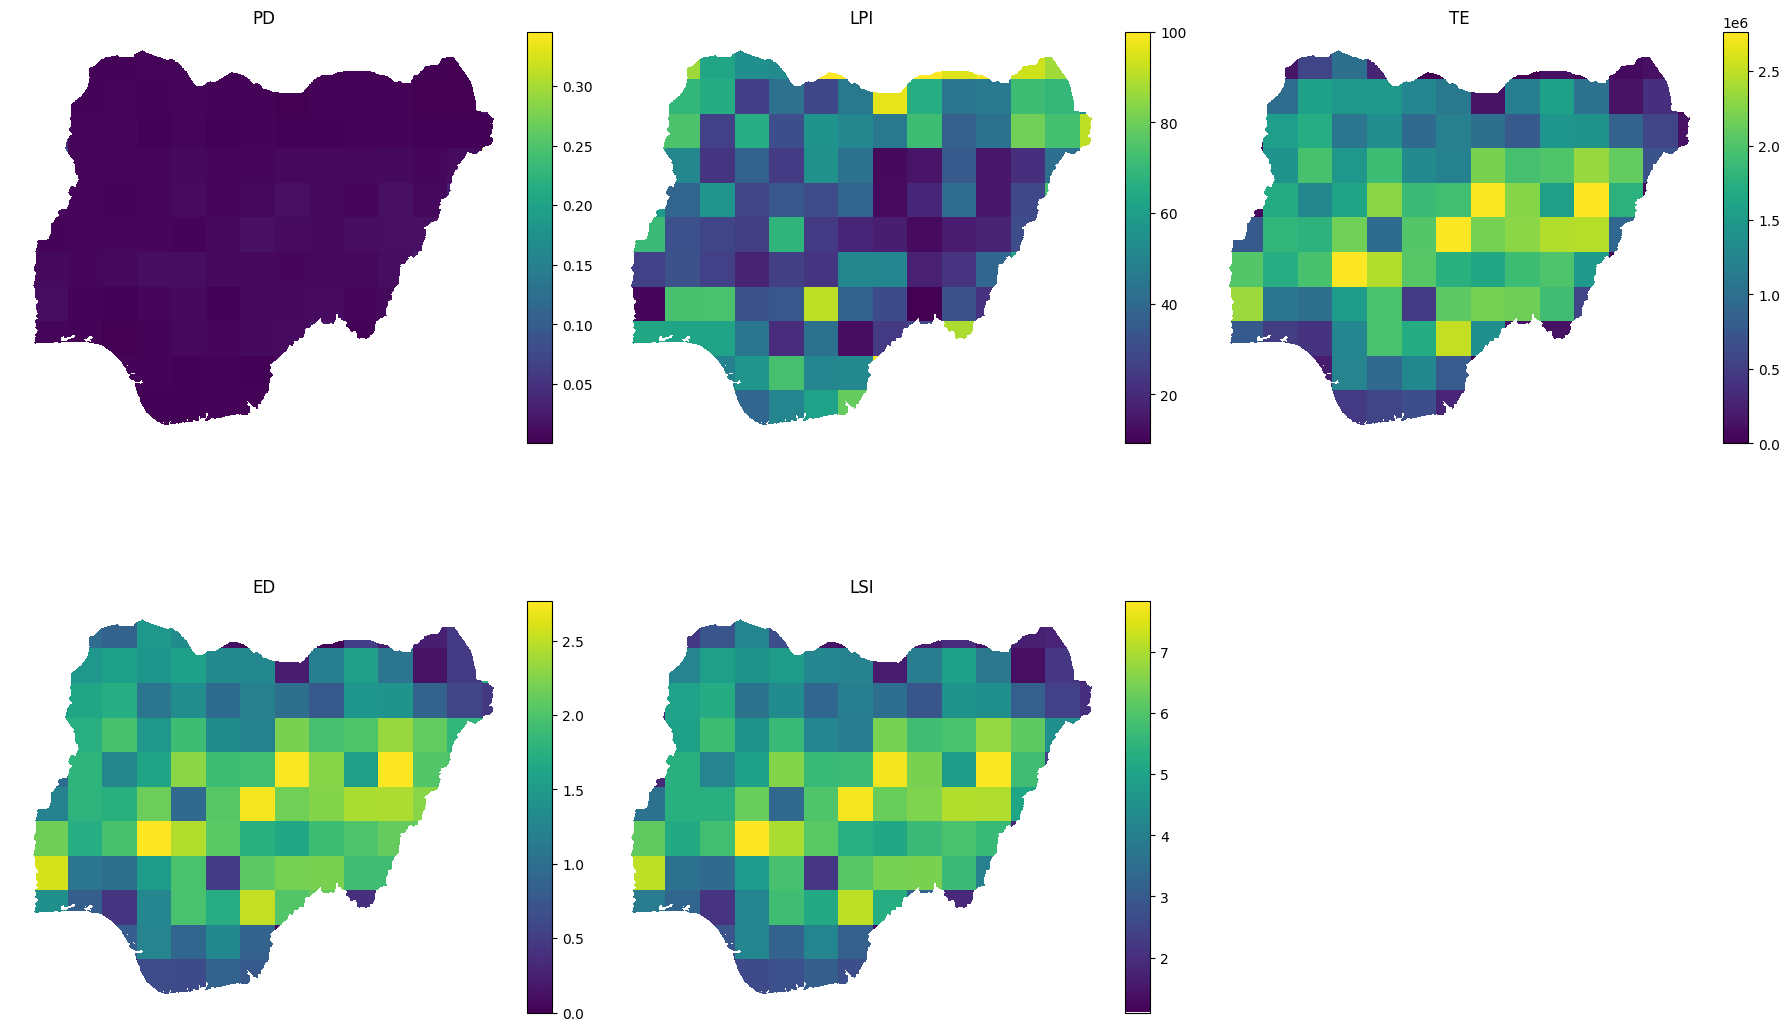

      id                                           geometry
116  117  POLYGON ((1198500.000 1477500.000, 1112850.000...
117  118  POLYGON ((1298500.000 1477500.000, 1198500.000...
118  119  MULTIPOLYGON (((1398500.000 1477500.000, 13958...
119  120  POLYGON ((1498500.000 1477500.000, 1398500.000...
120  121  POLYGON ((1498500.000 1477500.000, 1498500.000...


In [30]:
# Define the metrics and their titles
metrics = [
    'patch_density', 
    'largest_patch_index', 
    'total_edge', 
    'edge_density', 
    'landscape_shape_index'
]
metric_titles = {
    'patch_density': 'PD',
    'largest_patch_index': 'LPI',
    'total_edge': 'TE',
    'edge_density': 'ED',
    'landscape_shape_index': 'LSI'
}

# Fill NaN values with 0 for all metrics
#for metric in metrics:
#    grid_gdf[metric] = grid_gdf[metric].fillna(0)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Plot the data with min-max normalization
    merged_gdf.plot(column=metric, ax=ax, legend=True, cax=cax, cmap='viridis')
    ax.set_title(metric_titles[metric])
    ax.set_axis_off()

# Remove any unused subplots
if len(metrics) < len(axes):
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('all_output/landscape_level_metrics_14km.png')
plt.savefig('all_output/landscape_level_metrics_14km.svg')
plt.show()

print(grid_gdf.tail(5))